# Get 6C Data for Event

In [1]:
import os
import obspy as obs
import matplotlib.pyplot as plt

from obspy.clients.fdsn import Client

from andbro__read_sds import __read_sds

In [2]:
if os.uname().nodename == 'lighthouse':
    root_path = '/home/andbro/'
    data_path = '/home/andbro/kilauea-data/'
    archive_path = '/home/andbro/freenas/'
elif os.uname().nodename == 'kilauea':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'

## Configurations

In [3]:
config = {}

## output path for figures
config['path_to_figs'] = data_path+"romy_events/figures/"

config['path_to_outdata'] = data_path+"romy_events/data/"

config['path_to_sds'] = archive_path+"romy_archive/"

config['path_to_inventory'] = root_path+"Documents/ROMY/stationxml_ringlaser/"

## BSPF coordinates
config['ROMY_lon'] = 11.275501
config['ROMY_lat'] = 48.162941

config['submask'] = ""


## Eventtime
config['eventtime'] = obs.UTCDateTime("2023-10-25 13:40:00")

# config['event_name'] = "Italy"
# config['tbeg'] = obs.UTCDateTime("2023-10-25 13:45:00")
# config['tend'] = obs.UTCDateTime("2023-10-25 13:50:00")

# config['event_name'] = "Morocco"
# config['tbeg'] = obs.UTCDateTime("2023-09-08 22:00")
# config['tend'] = obs.UTCDateTime("2023-09-08 23:00")

# config['event_name'] = "Morocco2"
# config['tbeg'] = obs.UTCDateTime("2023-09-08 22:30")
# config['tend'] = obs.UTCDateTime("2023-09-08 23:30")

# config['event_name'] = "Mindanao" ## M7-6
# config['tbeg'] = obs.UTCDateTime("2023-12-02 14:37")
# config['tend'] = obs.UTCDateTime("2023-12-02 17:00")

config['event_name'] = "Mindanao2" ## M6.6
config['tbeg'] = obs.UTCDateTime("2023-12-03 10:35")
config['tend'] = obs.UTCDateTime("2023-12-03 12:35")


config['fmin'] = 0.01
config['fmax'] = 10

## Load Data

#### Find event in catalog

In [4]:
event = Client("IRIS").get_events(starttime=config['tbeg'], endtime=config['tend'], minmagnitude=4.0)
event = event[0]

#### Load inventory

In [5]:
romy_inv = obs.read_inventory(config['path_to_inventory']+"dataless.seed.BW_ROMY")
seis_inv = obs.read_inventory(config['path_to_inventory']+"dataless.seed.BW_DROMY")

In [6]:
st0 = obs.Stream()

st0 += __read_sds(config['path_to_sds'], "BW.ROMY.10.BJZ", config['tbeg']-1, config['tend']+1)
st0 += __read_sds(config['path_to_sds'], "BW.ROMY..BJU", config['tbeg']-1, config['tend']+1)
st0 += __read_sds(config['path_to_sds'], "BW.ROMY..BJV", config['tbeg']-1, config['tend']+1)

if len(st0) > 3:
    st0.merge(fill_value="interpolate")

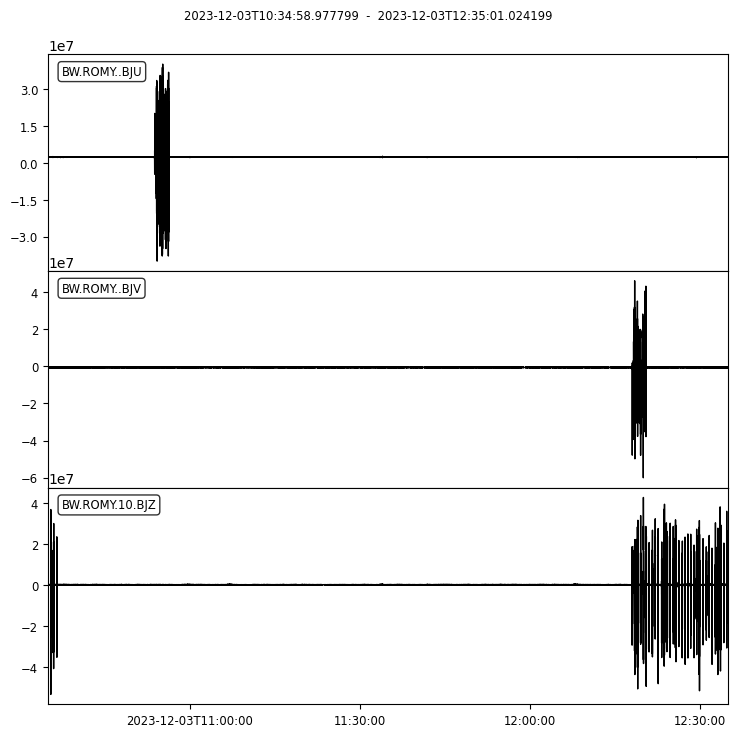

In [7]:
st0.plot(equal_scale=False);

In [ ]:
acc = __read_sds(config['path_to_sds'], "BW.DROMY..HH*", config['tbeg']-1, config['tend']+1)

acc.remove_response(seis_inv, output="ACC")

acc.detrend("demean")

In [ ]:
acc.plot(equal_scale=False);

In [ ]:
st = st0.copy()

st.remove_sensitivity(romy_inv)

st.detrend("demean")
# st.taper(0.1)
# st.filter("bandpass", freqmin=config['fmin'], freqmax=config['fmax'], corners=4, zerophase=True)

st.plot(equal_scale=False);

In [ ]:
acc, st

In [ ]:
# st = st.rotate(method="->ZNE", inventory=romy_inv)

ori_z = romy_inv.get_orientation("BW.ROMY.10.BJZ")
ori_u = romy_inv.get_orientation("BW.ROMY..BJU")
ori_v = romy_inv.get_orientation("BW.ROMY..BJV")

romy_z = st.select(channel="*Z")[0].data
romy_u = st.select(channel="*U")[0].data
romy_v = st.select(channel="*V")[0].data

from obspy.signal.rotate import rotate2zne

romy_z, romy_n, romy_e =rotate2zne(
                                   romy_z, ori_z['azimuth'], ori_z['dip'],
                                   romy_u, ori_u['azimuth'], ori_u['dip'],
                                   romy_v, ori_v['azimuth'], ori_v['dip'],
                                   inverse=False
                                  )

st_new = st.copy()

st_new.select(channel="*Z")[0].data = romy_z
st_new.select(channel="*U")[0].data = romy_n
st_new.select(channel="*V")[0].data = romy_e

st_new.select(channel="*U")[0].stats.channel = "BJN"
st_new.select(channel="*V")[0].stats.channel = "BJE"


In [ ]:
st_new.plot(equal_scale=False);

In [ ]:
test = st_new.copy().trim(config['tbeg']+10*60, config['tend']-0*60)
test.detrend("linear")
test.taper(0.1)
test.filter("bandpass", freqmin=0.001, freqmax=0.1, corners=4, zerophase=True)
test.plot();

In [ ]:
t1, t2 = config['tbeg']+11*60, config['tend']-0*60

st = st.copy().trim(t1, t2)
st_new = st_new.copy().trim(t1, t2)
acc = acc.copy().trim(t1, t2)


## Compare Waveforms

In [ ]:
def __makeplot_waveform_comparison(st1, st2):

    fig, ax = plt.subplots(3, 1, figsize=(15, 5), sharex=True)

    font = 14

    rot_scaling = 1e9

    lw = 1

    ax[0].plot(st1.select(channel="*Z")[0].times(), st1.select(channel="*Z")[0].data*rot_scaling, lw=lw, label="Z", color="darkred", ls="-", zorder=3)
    ax[0].plot(st2.select(channel="*Z")[0].times(), st2.select(channel="*Z")[0].data*rot_scaling, lw=lw, label="Z", color="black", zorder=2)

    ax[1].plot(st1.select(channel="*U")[0].times(), st1.select(channel="*U")[0].data*rot_scaling, lw=lw, label="U", color="darkred", ls="-", zorder=3)
    ax[1].plot(st2.select(channel="*N")[0].times(), st2.select(channel="*N")[0].data*rot_scaling, lw=lw, label="N", color="black", zorder=2)

    ax[2].plot(st1.select(channel="*V")[0].times(), st1.select(channel="*V")[0].data*rot_scaling, lw=lw, label="V", color="darkred", ls="-", zorder=3)
    ax[2].plot(st2.select(channel="*E")[0].times(), st2.select(channel="*E")[0].data*rot_scaling, lw=lw, label="E", color="black", zorder=2)

    ax00 = ax[0].twinx()
    diff_Z = ( abs(st1.select(channel="*Z")[0].data - st2.select(channel="*Z")[0].data)*rot_scaling )
    ax00.fill_between(st2.select(channel="*Z")[0].times(), diff_Z, color="grey", alpha=0.5, zorder=1)
    ax00.set_ylim(-1, 10)
    ax00.set_ylabel("Z - Z (nrad/s)", color="darkgrey")

    ax11 = ax[1].twinx()
    diff_N = ( abs(st1.select(channel="*U")[0].data - st2.select(channel="*N")[0].data)*rot_scaling )
    ax11.fill_between(st2.select(channel="*N")[0].times(), diff_N, color="grey", alpha=0.5, zorder=1)
    ax11.set_ylim(-1, 10)
    ax11.set_ylabel("U - N (nrad/s)", color="darkgrey")

    ax22 = ax[2].twinx()
    diff_E = ( abs(st1.select(channel="*V")[0].data - st2.select(channel="*E")[0].data)*rot_scaling )
    ax22.fill_between(st2.select(channel="*E")[0].times(), diff_E, color="grey", alpha=0.5, zorder=1)
    ax22.set_ylim(-1, 10)
    ax22.set_ylabel("V - E (nrad/s)", color="darkgrey")

    for i in range(3):
        ax[i].legend(loc=1, ncols=4)
        ax[i].grid(which="both", alpha=0.5)
        # ax[i].set_xscale("log")
        ax[i].set_ylabel(r"$\Omega$ (nrad/s)")

    ax[2].set_xlabel("Time (s)")
    ax[0].set_title(f"{config['tbeg'].date} {str(config['tbeg'].time).split('.')[0]} UTC | {config['fmin']}-{config['fmax']} Hz ")

    plt.show();
    return fig

In [ ]:
config['fmin'] = 0.01
config['fmax'] = 0.1

st_cp = st.copy()
st_cp = st_cp.detrend("demean");
st_cp = st_cp.taper(0.1);
st_cp = st_cp.filter("bandpass", freqmin=config['fmin'], freqmax=config['fmax'], corners=4, zerophase=True);
st_cp.trim(config['tbeg']+600, config['tend'])

st_rot_cp = st_new.copy()
st_rot_cp = st_rot_cp.detrend("demean");
st_rot_cp = st_rot_cp.taper(0.1);
st_rot_cp = st_rot_cp.filter("bandpass", freqmin=config['fmin'], freqmax=config['fmax'], corners=4, zerophase=True);

st_rot_cp.trim(config['tbeg']+600, config['tend'])



fig = __makeplot_waveform_comparison(st_cp, st_rot_cp)

fig.savefig(config['path_to_figs']+f"ROMY_{config['event_name']}_waveforms.png", format="png", dpi=200, bbox_inches='tight');

In [ ]:
def __makeplot_spectra_comparison(st1, st2):

    def __multitaper_psd(arr, dt, n_win=5):

        import multitaper as mt

        out_psd = mt.MTSpec(arr, nw=n_win, kspec=0, dt=dt)

        _f, _psd = out_psd.rspec()

        f = _f.reshape(_f.size)
        psd = _psd.reshape(_psd.size)

        ## 95% confidence interval
        # _psd95 = out_psd.jackspec()
        # psd95_lower, psd95_upper = psd95[::2, 0], psd95[::2, 1]

        return f, psd

    f1_Z, psd1_Z = __multitaper_psd(st1.select(channel="*Z")[0].data, st1[0].stats.delta ,n_win=10)
    f2_Z, psd2_Z = __multitaper_psd(st2.select(channel="*Z")[0].data, st2[0].stats.delta ,n_win=10)

    f1_U, psd1_U = __multitaper_psd(st1.select(channel="*U")[0].data, st1[0].stats.delta ,n_win=10)
    f2_N, psd2_N = __multitaper_psd(st2.select(channel="*N")[0].data, st2[0].stats.delta ,n_win=10)

    f1_V, psd1_V = __multitaper_psd(st1.select(channel="*V")[0].data, st1[0].stats.delta ,n_win=10)
    f2_E, psd2_E = __multitaper_psd(st2.select(channel="*E")[0].data, st2[0].stats.delta ,n_win=10)


    fig, ax = plt.subplots(3, 1, figsize=(15, 5), sharex=True)

    font = 14

    rot_scaling = 1e9

    lw = 1

    ax[0].plot(f1_Z, psd1_Z, lw=lw, label="Z", color="darkred", ls="-", zorder=3)
    ax[0].plot(f2_Z, psd2_Z, lw=lw, label="Z", color="black", zorder=2)

    ax[1].plot(f1_U, psd1_U, lw=lw, label="U", color="darkred", ls="-", zorder=3)
    ax[1].plot(f2_N, psd2_N, lw=lw, label="N", color="black", zorder=2)

    ax[2].plot(f1_V, psd1_V, lw=lw, label="V", color="darkred", ls="-", zorder=3)
    ax[2].plot(f2_E, psd2_E, lw=lw, label="E", color="black", zorder=2)


    for i in range(3):
        ax[i].legend(loc=1, ncols=4)
        ax[i].set_xscale("log")
        ax[i].set_yscale("log")
        ax[i].grid(which="both", alpha=0.5)
        ax[i].set_ylabel(r"PSD (rad$^2$/s$^2$/Hz)")
        ax[i].set_xlim(1e-3, 1e1)

    ax[2].set_xlabel("Frequency (Hz)")
    ax[0].set_title(f"{config['tbeg'].date} {str(config['tbeg'].time).split('.')[0]} UTC | {config['fmin']}-{config['fmax']} Hz ")

    plt.show();
    return fig

In [ ]:
fig = __makeplot_spectra_comparison(st_cp, st_rot_cp)

## Write Data

In [ ]:
st_all = st_new.copy();
st_all += acc.copy();

st_all.resample(20, no_filter=False)

st_all.trim(config['tbeg'], config['tend'])

st_all.plot(equal_scale=False);

st_all.write(config['path_to_outdata']+f"ROMY_{config['event_name']}_{str(config['tbeg'].date).replace('-','')}_{str(config['tbeg'].time).split('.')[0]}_6C.mseed", format="MSEED");
